## Model Training (for Google Colab)

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics        import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models     import Sequential
from tensorflow.keras.layers     import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks  import EarlyStopping

SEED = 26
np.random.seed(SEED)
tf.random.set_seed(SEED)


# 1. Load daily data – ensure continuous "D" frequency
# ---------------------------------------------------------------
DATA_PATH = Path("water_levels_daily.csv")
assert DATA_PATH.exists(), f"Cannot find data file at {DATA_PATH}"  # fail fast

df = pd.read_csv(DATA_PATH, parse_dates=["timestamp"])

# resample to daily frequency and linear‑interpolate gaps (if any)
daily = (
    df.set_index("timestamp")["value"]
      .resample("D").mean()
      .interpolate()
)

daily_df = daily.to_frame(name="value")
daily_df

# 2. Deterministic calendar features (annual & weekly)
# ---------------------------------------------------------------
# -- annual cycle (≈365.25 days)
doy = daily_df.index.dayofyear  # 1 … 365 / 366
ang_yr = 2 * np.pi * doy / 365.25

daily_df["sin365"] = np.sin(ang_yr)
daily_df["cos365"] = np.cos(ang_yr)

# -- weekly cycle (7 days)
dow = daily_df.index.dayofweek  # Monday==0
ang_wk = 2 * np.pi * dow / 7

daily_df["sin7"] = np.sin(ang_wk)
daily_df["cos7"] = np.cos(ang_wk)

# Keep target in the **first** column
daily_df = daily_df[["value", "sin365", "cos365", "sin7", "cos7"]]


# 3. Dynamic Hochwasserschutzraum cap – daily resolution
# ---------------------------------------------------------------
anchor_template = [
    ("11-01", 237.30),  # 1 Nov
    ("12-15", 237.30),
    ("01-01", 239.61),
    ("02-01", 241.71),
    ("03-01", 242.70),
    ("04-01", 244.10),
    ("05-01", 244.95),  # 1 May
]

def compute_max_level_series(dates):
    """Return a Series of the management upper bound for each date."""

    def cap_on(day: pd.Timestamp) -> float:
        # management year starts 1 Nov
        y0 = day.year if day.month >= 11 else day.year - 1
        pts = []
        for mm_dd, lvl in anchor_template:
            mm, dd = map(int, mm_dd.split("-"))
            yr = y0 if mm >= 11 else y0 + 1
            try:
                pts.append((pd.Timestamp(yr, mm, dd), lvl))
            except ValueError:  # 29 Feb on non‑leap year
                pts.append((pd.Timestamp(yr, 2, 28), lvl))
        pts.sort(key=lambda x: x[0])
        # outside Nov → May window: reservoir may be full
        if day < pts[0][0] or day >= pts[-1][0]:
            return pts[-1][1]
        # linear interpolate within segment
        for (d0, l0), (d1, l1) in zip(pts, pts[1:]):
            if d0 <= day <= d1:
                frac = (day - d0) / (d1 - d0)
                return l0 + frac * (l1 - l0)
        return pts[-1][1]  # fallback

    caps = [cap_on(d) for d in dates]
    return pd.Series(caps, index=dates, name="max_level_m")

max_level = compute_max_level_series(daily_df.index)


# 4. Train / validation split
# ---------------------------------------------------------------
train_df      = daily_df.loc[: "2017-12-31"]
validation_df = daily_df.loc["2018-01-01" : "2020-12-31"]


# 5. Scaling – fit on training only, apply to all
# ---------------------------------------------------------------
scaler = StandardScaler()
train_scaled      = scaler.fit_transform(train_df)
validation_scaled = scaler.transform(validation_df)


# 6. Window generator (sliding) – 365‑day lookback, 28‑day horizon
# ---------------------------------------------------------------
LOOKBACK = 365   # past one calendar year
HORIZON  = 28    # 28 days ≈ 4 weeks


def make_windows(arr: np.ndarray, lookback: int = LOOKBACK, horizon: int = HORIZON):
    """Return X (window, time, features) and y (target)."""
    X, y = [], []
    for i in range(lookback, len(arr) - horizon + 1):
        X.append(arr[i - lookback : i, :])        # all features
        y.append(arr[i + horizon - 1, 0])         # only the target column
    return np.array(X), np.array(y)

# --- training windows
X_train, y_train = make_windows(train_scaled)

# --- validation windows (need padding from the tail of train)
PAD_LEN   = LOOKBACK + HORIZON - 1  # number of extra rows required
val_block = np.vstack([train_scaled[-PAD_LEN:], validation_scaled])
X_val, y_val = make_windows(val_block)

# Shapes to float32
X_train = X_train.astype("float32")
X_val   = X_val.astype("float32")


# 7. LSTM model
# ---------------------------------------------------------------
print("-" * 50)
print("Input shape :", X_train.shape)
print("Features    :", list(daily_df.columns))
print("-" * 50)

model = Sequential([
    Input(shape=(LOOKBACK, X_train.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(1),
])

model.compile(optimizer="adam", loss="mse")

es = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[es],
    verbose=1,
)

# Save model
model.save("water_level_lstm.keras")  # lightweight .keras file
joblib.dump(scaler, "LSTM_standard_scaler.joblib")

# 8. Forecast on validation set – inverse scaling
# ---------------------------------------------------------------
val_pred_scaled = model.predict(X_val, verbose=0).flatten()
val_true_scaled = y_val  # already 1‑D

target_mean  = scaler.mean_[0]
target_scale = scaler.scale_[0]

val_pred = val_pred_scaled * target_scale + target_mean
val_true = val_true_scaled * target_scale + target_mean


# 9. Apply dynamic cap & min constraint
# ---------------------------------------------------------------
MIN_VAL = 205.0
dyn_cap = max_level.loc[validation_df.index].values

pred_capped = np.maximum(val_pred, MIN_VAL)
pred_final  = np.minimum(pred_capped, dyn_cap)


# 10. Metrics
# ---------------------------------------------------------------
results_df = pd.DataFrame({
    "Actual":    val_true,
    "Predicted": pred_final,
}, index=validation_df.index)

rmse = np.sqrt(mean_squared_error(results_df["Actual"], results_df["Predicted"]))
mae  = mean_absolute_error(results_df["Actual"], results_df["Predicted"])

print("-" * 50)
print(f"Validation MAE  : {mae:6.3f} m")
print(f"Validation RMSE : {rmse:6.3f} m")
print("-" * 50)


# 11. Visual diagnostics
# ---------------------------------------------------------------
plt.figure(figsize=(12, 4))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.title("LSTM loss history")
plt.legend()
plt.tight_layout()
plt.savefig("LSTM_loss_history.png")
plt.show()

# --- forecast vs. actuals & cap
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(results_df.index, results_df["Actual"], label="Actual", lw=0.8)
ax.plot(results_df.index, results_df["Predicted"], label="Forecast (28‑d)", color="red", lw=0.8)
ax.plot(max_level.loc[results_df.index], label="Hochwasserschutzraum (cap)", color="green", ls="--", lw=1)
ax.set_ylabel("Water level (m ü. NN)")
ax.set_title("Edersee – 28‑day‑ahead rolling forecast (daily model)")
ax.legend(loc="lower left")
plt.tight_layout()
plt.savefig("LSTM_forecast_vs_actual.png")
plt.show()

## Load Model and Predict Validation Set

--------------------------------------------------
Validation MAE  : 1.4827 m
Validation RMSE : 1.8725 m
--------------------------------------------------


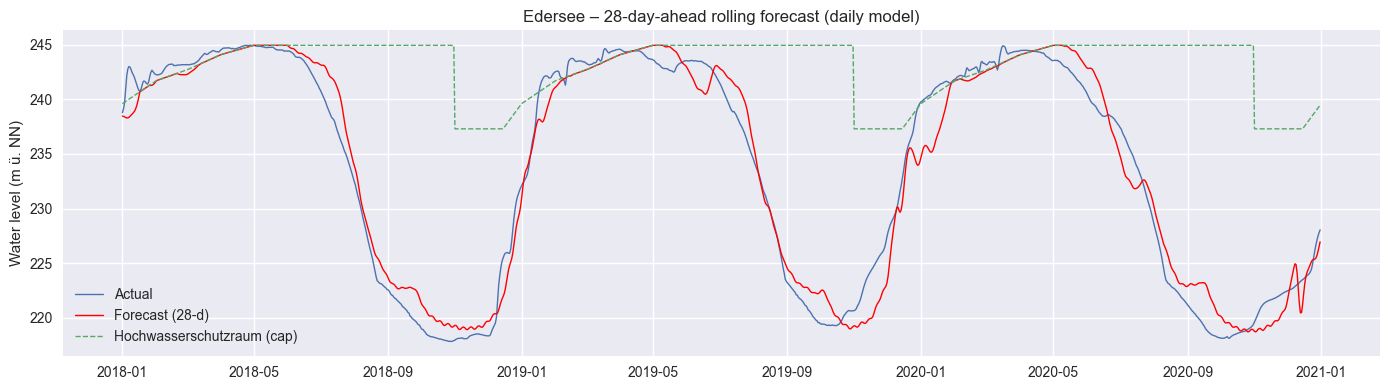

In [7]:
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf

# Set style for the plots
plt.style.use('seaborn-v0_8')

# ------------------------------------------------------------------
# 1. Check that the required artefacts and data are available
# ------------------------------------------------------------------
DATA_PATH   = Path("../data/processed/water_levels_daily.csv")
MODEL_PATH  = Path("../models/water_level_lstm.keras")
SCALER_PATH = Path("../models/LSTM_standard_scaler.joblib")

missing = [p for p in [DATA_PATH, MODEL_PATH, SCALER_PATH] if not p.exists()]
if missing:
    raise FileNotFoundError(
        "The following file(s) are missing from the working directory:\n"
        + "\n".join(f" • {m}" for m in missing)
        + "\nPlease upload them and re-run this cell."
    )

# ------------------------------------------------------------------
# 2. Re-create the deterministic feature engineering pipeline
# ------------------------------------------------------------------
LOOKBACK = 365   # one year of look-back
HORIZON  = 28    # 28-day forecast horizon

def make_windows(arr: np.ndarray, lookback: int = LOOKBACK, horizon: int = HORIZON):
    X, y = [], []
    for i in range(lookback, len(arr) - horizon + 1):
        X.append(arr[i - lookback : i, :])
        y.append(arr[i + horizon - 1, 0])   # only the target column
    return np.array(X, dtype="float32"), np.array(y, dtype="float32")

anchor_template = [
    ("11-01", 237.30),  # 1 Nov
    ("12-15", 237.30),
    ("01-01", 239.61),
    ("02-01", 241.71),
    ("03-01", 242.70),
    ("04-01", 244.10),
    ("05-01", 244.95),  # 1 May
]

def compute_max_level_series(dates):
    def cap_on(day: pd.Timestamp) -> float:
        y0 = day.year if day.month >= 11 else day.year - 1
        pts = []
        for mm_dd, lvl in anchor_template:
            mm, dd  = map(int, mm_dd.split("-"))
            yr      = y0 if mm >= 11 else y0 + 1
            try:
                pts.append((pd.Timestamp(yr, mm, dd), lvl))
            except ValueError:          # 29 Feb on non-leap year
                pts.append((pd.Timestamp(yr, 2, 28), lvl))
        pts.sort(key=lambda x: x[0])

        # outside 1 Nov ↔ 1 May window: reservoir may be full
        if day < pts[0][0] or day >= pts[-1][0]:
            return pts[-1][1]

        for (d0, l0), (d1, l1) in zip(pts, pts[1:]):
            if d0 <= day <= d1:
                frac = (day - d0) / (d1 - d0)
                return l0 + frac * (l1 - l0)
        # fallback
        return pts[-1][1]

    return pd.Series([cap_on(d) for d in dates], index=dates, name="max_level_m")


# ------------------------------------------------------------------
# 3. Load raw data and build daily feature frame
# ------------------------------------------------------------------
df = pd.read_csv(DATA_PATH, parse_dates=["timestamp"])

daily = (
    df.set_index("timestamp")["value"]
      .resample("D").mean()
      .interpolate()
)

daily_df = daily.to_frame(name="value")

# Annual cycle (≈365.25 days)
doy     = daily_df.index.dayofyear
ang_yr  = 2 * np.pi * doy / 365.25
daily_df["sin365"] = np.sin(ang_yr)
daily_df["cos365"] = np.cos(ang_yr)

# Weekly cycle (7 days)
dow     = daily_df.index.dayofweek      # Monday == 0
ang_wk  = 2 * np.pi * dow / 7
daily_df["sin7"]  = np.sin(ang_wk)
daily_df["cos7"]  = np.cos(ang_wk)

# Keep target first
daily_df = daily_df[["value", "sin365", "cos365", "sin7", "cos7"]]

# ------------------------------------------------------------------
# 4. Train / validation split (fixed to reproduce original)
# ------------------------------------------------------------------
train_df      = daily_df.loc[: "2017-12-31"]
validation_df = daily_df.loc["2018-01-01" : "2020-12-31"]

# ------------------------------------------------------------------
# 5. Re-apply the stored StandardScaler
# ------------------------------------------------------------------
scaler = joblib.load(SCALER_PATH)

train_scaled      = scaler.transform(train_df)
validation_scaled = scaler.transform(validation_df)

# ------------------------------------------------------------------
# 6. Build validation windows (need padding from tail of train)
# ------------------------------------------------------------------
PAD_LEN  = LOOKBACK + HORIZON - 1
val_block = np.vstack([train_scaled[-PAD_LEN:], validation_scaled])
X_val, y_val = make_windows(val_block)

# ------------------------------------------------------------------
# 7. Load the trained LSTM model and generate predictions
# ------------------------------------------------------------------
model = tf.keras.models.load_model(MODEL_PATH)

val_pred_scaled = model.predict(X_val, verbose=0).flatten()

# Inverse transform for the target
target_mean  = scaler.mean_[0]
target_scale = scaler.scale_[0]

val_pred = val_pred_scaled * target_scale + target_mean
val_true = y_val * target_scale + target_mean

# ------------------------------------------------------------------
# 8. Apply minimum constraint and dynamic Hochwasserschutzraum cap
# ------------------------------------------------------------------
MIN_VAL   = 205.0
dyn_cap   = compute_max_level_series(validation_df.index).values

pred_capped = np.maximum(val_pred, MIN_VAL)
pred_final  = np.minimum(pred_capped, dyn_cap)

# ------------------------------------------------------------------
# 9. Compute metrics
# ------------------------------------------------------------------
mae  = mean_absolute_error(val_true, pred_final)
rmse = np.sqrt(mean_squared_error(val_true, pred_final))

print("-" * 50)
print(f"Validation MAE  : {mae:6.4f} m")
print(f"Validation RMSE : {rmse:6.4f} m")
print("-" * 50)

# ------------------------------------------------------------------
# 10. Plot forecast vs. actuals & cap
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(validation_df.index, val_true, label="Actual", linewidth=1)
ax.plot(validation_df.index, pred_final, label="Forecast (28-d)", linewidth=1, color="red")
ax.plot(validation_df.index, dyn_cap, label="Hochwasserschutzraum (cap)", linestyle="--", linewidth=1)
ax.set_ylabel("Water level (m ü. NN)")
ax.set_title("Edersee – 28-day-ahead rolling forecast (daily model)")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()


--------------------------------------------------
Validation MAE  : 1.4760 m
Validation RMSE : 1.8724 m
--------------------------------------------------


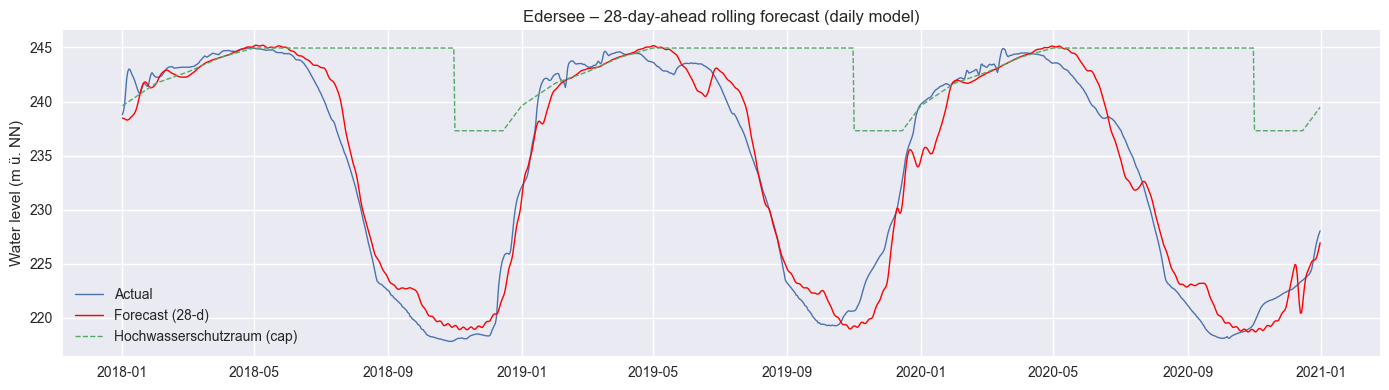

In [6]:
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf

# Set style for the plots
plt.style.use('seaborn-v0_8')

# ------------------------------------------------------------------
# 1. Check that the required artefacts and data are available
# ------------------------------------------------------------------
DATA_PATH   = Path("../data/processed/water_levels_daily.csv")
MODEL_PATH  = Path("../models/water_level_lstm.keras")
SCALER_PATH = Path("../models/LSTM_standard_scaler.joblib")

missing = [p for p in [DATA_PATH, MODEL_PATH, SCALER_PATH] if not p.exists()]
if missing:
    raise FileNotFoundError(
        "The following file(s) are missing from the working directory:\n"
        + "\n".join(f" • {m}" for m in missing)
        + "\nPlease upload them and re-run this cell."
    )

# ------------------------------------------------------------------
# 2. Re-create the deterministic feature engineering pipeline
# ------------------------------------------------------------------
LOOKBACK = 365   # one year of look-back
HORIZON  = 28    # 28-day forecast horizon

def make_windows(arr: np.ndarray, lookback: int = LOOKBACK, horizon: int = HORIZON):
    X, y = [], []
    for i in range(lookback, len(arr) - horizon + 1):
        X.append(arr[i - lookback : i, :])
        y.append(arr[i + horizon - 1, 0])   # only the target column
    return np.array(X, dtype="float32"), np.array(y, dtype="float32")

anchor_template = [
    ("11-01", 237.30),  # 1 Nov
    ("12-15", 237.30),
    ("01-01", 239.61),
    ("02-01", 241.71),
    ("03-01", 242.70),
    ("04-01", 244.10),
    ("05-01", 244.95),  # 1 May
]

def compute_max_level_series(dates):
    def cap_on(day: pd.Timestamp) -> float:
        y0 = day.year if day.month >= 11 else day.year - 1
        pts = []
        for mm_dd, lvl in anchor_template:
            mm, dd  = map(int, mm_dd.split("-"))
            yr      = y0 if mm >= 11 else y0 + 1
            try:
                pts.append((pd.Timestamp(yr, mm, dd), lvl))
            except ValueError:          # 29 Feb on non-leap year
                pts.append((pd.Timestamp(yr, 2, 28), lvl))
        pts.sort(key=lambda x: x[0])

        # outside 1 Nov ↔ 1 May window: reservoir may be full
        if day < pts[0][0] or day >= pts[-1][0]:
            return pts[-1][1]

        for (d0, l0), (d1, l1) in zip(pts, pts[1:]):
            if d0 <= day <= d1:
                frac = (day - d0) / (d1 - d0)
                return l0 + frac * (l1 - l0)
        # fallback
        return pts[-1][1]

    return pd.Series([cap_on(d) for d in dates], index=dates, name="max_level_m")


# ------------------------------------------------------------------
# 3. Load raw data and build daily feature frame
# ------------------------------------------------------------------
df = pd.read_csv(DATA_PATH, parse_dates=["timestamp"])

daily = (
    df.set_index("timestamp")["value"]
      .resample("D").mean()
      .interpolate()
)

daily_df = daily.to_frame(name="value")

# Annual cycle (≈365.25 days)
doy     = daily_df.index.dayofyear
ang_yr  = 2 * np.pi * doy / 365.25
daily_df["sin365"] = np.sin(ang_yr)
daily_df["cos365"] = np.cos(ang_yr)

# Weekly cycle (7 days)
dow     = daily_df.index.dayofweek      # Monday == 0
ang_wk  = 2 * np.pi * dow / 7
daily_df["sin7"]  = np.sin(ang_wk)
daily_df["cos7"]  = np.cos(ang_wk)

# Keep target first
daily_df = daily_df[["value", "sin365", "cos365", "sin7", "cos7"]]

# ------------------------------------------------------------------
# 4. Train / validation split (fixed to reproduce original)
# ------------------------------------------------------------------
train_df      = daily_df.loc[: "2017-12-31"]
validation_df = daily_df.loc["2018-01-01" : "2020-12-31"]

# ------------------------------------------------------------------
# 5. Re-apply the stored StandardScaler
# ------------------------------------------------------------------
scaler = joblib.load(SCALER_PATH)

train_scaled      = scaler.transform(train_df)
validation_scaled = scaler.transform(validation_df)

# ------------------------------------------------------------------
# 6. Build validation windows (need padding from tail of train)
# ------------------------------------------------------------------
PAD_LEN  = LOOKBACK + HORIZON - 1
val_block = np.vstack([train_scaled[-PAD_LEN:], validation_scaled])
X_val, y_val = make_windows(val_block)

# ------------------------------------------------------------------
# 7. Load the trained LSTM model and generate predictions
# ------------------------------------------------------------------
model = tf.keras.models.load_model(MODEL_PATH)

val_pred_scaled = model.predict(X_val, verbose=0).flatten()

# Inverse transform for the target
target_mean  = scaler.mean_[0]
target_scale = scaler.scale_[0]

pred_final = val_pred_scaled * target_scale + target_mean
val_true = y_val * target_scale + target_mean

# ------------------------------------------------------------------
# 8. Apply minimum constraint and dynamic Hochwasserschutzraum cap
# ------------------------------------------------------------------
# MIN_VAL   = 205.0
# MAX_VAL = 245

# pred_final = np.minimum(np.maximum(pred_final, MIN_VAL), MAX_VAL)
# pred_final  = np.minimum(pred_capped, dyn_cap)

# ------------------------------------------------------------------
# 9. Compute metrics
# ------------------------------------------------------------------
mae  = mean_absolute_error(val_true, pred_final)
rmse = np.sqrt(mean_squared_error(val_true, pred_final))

print("-" * 50)
print(f"Validation MAE  : {mae:6.4f} m")
print(f"Validation RMSE : {rmse:6.4f} m")
print("-" * 50)

# ------------------------------------------------------------------
# 10. Plot forecast vs. actuals & cap
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(validation_df.index, val_true, label="Actual", linewidth=1)
ax.plot(validation_df.index, pred_final, label="Forecast (28-d)", linewidth=1, color="red")
ax.plot(validation_df.index, dyn_cap, label="Hochwasserschutzraum (cap)", linestyle="--", linewidth=1)
ax.set_ylabel("Water level (m ü. NN)")
ax.set_title("Edersee – 28-day-ahead rolling forecast (daily model)")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()
